In [44]:
import wandb, json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

api = wandb.Api(timeout=120)


runs = api.runs("emerge_/adaptive", filters={"tags": {"$in": ["ent_closerLook", "3seeds-ent-disc-sweep"]}})
print(len(runs))

buckets = defaultdict(lambda: {True: [], False: []})

for r in runs:
    # last logged value of environment/perf
    hist = r.history(keys=["environment/perf"])
    col = hist["environment/perf"].dropna() if "environment/perf" in hist else []
    v = float(col.iloc[-1]) if len(col) > 0 else None
    if v is None or not np.isfinite(v):
        continue

    # r.config may sometimes be a JSON string; normalize to dict
    cfg_obj = r.config
    if isinstance(cfg_obj, str):
        cfg_obj = json.loads(cfg_obj)

    cfg_env = cfg_obj.get("env")['value']
    ent = cfg_env.get("entropy_weight_ub", None)
    disc = cfg_env.get("discount_weight_lb", None)
    oracle = cfg_env.get("oracle_mode", None)
    print(ent, disc, oracle, v)

    ent = float(ent)
    disc = float(disc)

    buckets[(disc, ent)][oracle].append(v)

212
0.1 0.9 True 0.62811279296875
0.1 0.8 True 0.50677490234375
0.001 0.8 True 0.630126953125
0.01 0.9 True 0.91680908203125
0.01 0.95 True 0.92266845703125
0.001 0.9 True 0.9334716796875
0.001 0.95 True 0.9154052734375
0.01 0.8 True 0.8707275390625
0.1 0.95 True 0.6162109375
0.5 0.8 True 0.36712646484375
0.5 0.9 True 0.362548828125
0.5 0.95 True 0.380615234375
0.001 0.8 False 0.9122314453125
0.001 0.9 False 0.84893798828125
0.001 0.95 False 0.906494140625
0.01 0.8 False 0.86895751953125
0.001 0.95 True 0.9071044921875
0.001 0.9 True 0.93548583984375
0.1 0.9 True 0.627685546875
0.01 0.8 True 0.87347412109375
0.01 0.95 True 0.923828125
0.01 0.9 True 0.8931884765625
0.001 0.8 True 0.854736328125
0.1 0.95 True 0.6435546875
0.01 0.9 False 0.9144287109375
0.1 0.95 False 0.6192626953125
0.01 0.95 False 0.91046142578125
0.1 0.8 False 0.633544921875
0.1 0.9 False 0.64739990234375
0.5 0.8 False 0.3643798828125
0.5 0.9 False 0.39093017578125
0.5 0.95 False 0.3924560546875
0.5 0.9 True 0.37426757

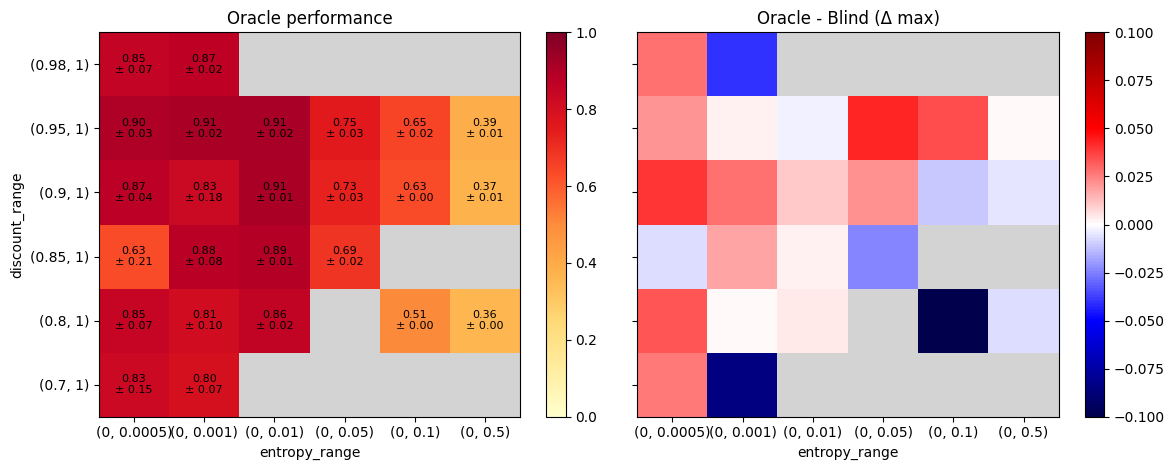

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm


entropy_values = [0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
discount_values = [0.70, 0.80, 0.85, 0.90, 0.95, 0.98]

M = np.full((len(discount_values), len(entropy_values)), np.nan)
mean = np.full((len(discount_values), len(entropy_values)), np.nan)
std = np.full((len(discount_values), len(entropy_values)), np.nan)
ent_idx = {e: i for i, e in enumerate(entropy_values)}
disc_idx = {d: i for i, d in enumerate(discount_values)}

for (disc, ent), d in buckets.items():
    if disc in disc_idx and ent in ent_idx and d[True] and d[False]:
        M[disc_idx[disc], ent_idx[ent]] = np.max(d[True]) - np.max(d[False])
        std[disc_idx[disc], ent_idx[ent]] = np.std(d[True])
        mean[disc_idx[disc], ent_idx[ent]] = np.mean(d[True])

# masks and colormaps
mean_ma = np.ma.masked_invalid(mean)
delta_ma = np.ma.masked_invalid(M)

perf_cmap = plt.cm.YlOrRd.copy()
perf_cmap.set_bad('lightgray')          # NaNs -> gray

delta_cmap = plt.cm.seismic.copy()
delta_cmap.set_bad('lightgray')

# color norms
perf_norm  = Normalize(vmin=0.0, vmax=1.0)
delta_norm = TwoSlopeNorm(vmin=-0.1, vcenter=0.0, vmax=0.1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharex=True, sharey=True)

# --- Left: Oracle performance (mean ± std) ---
im0 = axes[0].imshow(mean_ma, origin="lower", aspect="auto",
                     cmap=perf_cmap, norm=perf_norm)
for i in range(len(discount_values)):
    for j in range(len(entropy_values)):
        if not np.isnan(mean[i, j]):
            axes[0].text(j, i, f"{mean[i, j]:.2f}\n± {std[i, j]:.2f}",
                         ha="center", va="center", fontsize=8, color="black")
axes[0].set_title("Oracle performance")
axes[0].set_xlabel("entropy_range")
axes[0].set_ylabel("discount_range")
axes[0].set_xticks(range(len(entropy_values)))
axes[0].set_xticklabels([f"{(0, e)}" for e in entropy_values])
axes[0].set_yticks(range(len(discount_values)))
axes[0].set_yticklabels([f"{(d, 1)}" for d in discount_values])
cbar0 = fig.colorbar(im0, ax=axes[0])

# --- Right: Oracle advantage (Δ mean) ---
im1 = axes[1].imshow(delta_ma, origin="lower", aspect="auto",
                     cmap=delta_cmap, norm=delta_norm)
axes[1].set_title("Oracle - Blind (Δ max)")
axes[1].set_xlabel("entropy_range")
axes[1].set_xticks(range(len(entropy_values)))
# e -> (0, e)
axes[1].set_xticklabels([f"{(0, e)}" for e in entropy_values])
cbar1 = fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()